In [1]:
import numpy as np
from lab2_tools import *
from lab2_proto import *
import matplotlib.pyplot as plt 
from tqdm import trange
import pylab
pylab.rcParams['figure.figsize'] = (15, 5) 

In [2]:
example = np.load('lab2_example.npz',allow_pickle=True)['example'].item()
samplingrate_ex = example['samplingrate']
gender_ex = example['gender']
speaker_ex = example['speaker']
digit_ex = example['digit']
repetition_ex = example['repetition']
samples_ex = example['samples']
lmfcc_ex = example['lmfcc']

obsloglik_ex = example['obsloglik']
logalpha_ex = example['logalpha']
loglik_ex = example['loglik']
vloglik_ex = example['vloglik']
vpath_ex = example['vpath']
logbeta_ex = example['logbeta']
loggamma_ex = example['loggamma']

data = np.load('lab2_data.npz',allow_pickle=True)['data']
print("data of length:",len(data) )
print(data[1].keys())
print("============")

phoneHMMs_all = np.load('lab2_models_all.npz',allow_pickle=True)['phoneHMMs'].item()
phoneHMMs_one = np.load('lab2_models_onespkr.npz',allow_pickle=True)['phoneHMMs'].item()
print("phoneme HMM models:")
print(list(sorted(phoneHMMs_one.keys())))
print(phoneHMMs_one['ah'].keys())


data of length:44
dict_keys(['filename', 'samplingrate', 'gender', 'speaker', 'digit', 'repetition', 'samples', 'lmfcc'])
phoneme HMM models:
['ah', 'ao', 'ay', 'eh', 'ey', 'f', 'ih', 'iy', 'k', 'n', 'ow', 'r', 's', 'sil', 'sp', 't', 'th', 'uw', 'v', 'w', 'z']
dict_keys(['name', 'startprob', 'transmat', 'means', 'covars'])


In [3]:
hmm1 = phoneHMMs_one['f']
hmm2 = phoneHMMs_one['sp']
print("A1:")
print(hmm1['transmat'])
print("A2:")
print(hmm2['transmat'])
print("Pi1:")
print(hmm1['startprob'])
print("Pi2:")
print(hmm2['startprob'])
print("\n==========================================================")
print("==========================================================\n")
twoHMms=concatTwoHMMs(hmm1, hmm2)
print("A_c:")
print(twoHMms['transmat'])
print("Pi_c:")
print(twoHMms['startprob'])


A1:
[[0.8437548 0.1562452 0.        0.       ]
 [0.        0.7090222 0.2909778 0.       ]
 [0.        0.        0.3064214 0.6935785]
 [0.        0.        0.        1.       ]]
A2:
[[0.8144019 0.1855981]
 [0.        1.       ]]
Pi1:
[1. 0. 0. 0.]
Pi2:
[0.2403483 0.7596517]


A_c:
[[0.8437548  0.1562452  0.         0.         0.        ]
 [0.         0.7090222  0.2909778  0.         0.        ]
 [0.         0.         0.3064214  0.16670041 0.52687809]
 [0.         0.         0.         0.8144019  0.1855981 ]
 [0.         0.         0.         0.         1.        ]]
Pi_c:
[1. 0. 0. 0. 0.]


In [4]:
from prondict import *
slienced = {}
wordHMMs= {}
for i in prondict:
     slienced[i] = ['sil'] + prondict[i] + ['sil']
     wordHMMs[i] = concatHMMs(phoneHMMs_one, slienced[i])

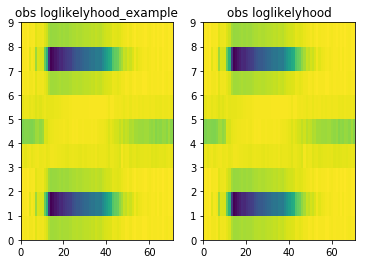

In [5]:
obsloglik = log_multivariate_normal_density_diag(
    example['lmfcc'], wordHMMs['o']['means'], wordHMMs['o']['covars'])
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(obsloglik_ex.T)
ax[0].set_title('obs loglikelyhood_example')
ax[1].set_title('obs loglikelyhood')
ax[1].pcolormesh(obsloglik.T)
plt.show()

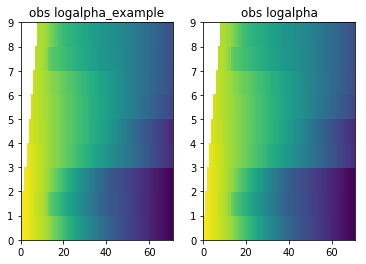

In [6]:
logPi = np.log(wordHMMs['o']['startprob'])
logA = np.log(wordHMMs['o']['transmat'])
logalpha=forward(obsloglik,logPi,logA)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(logalpha_ex.T)
ax[0].set_title('obs logalpha_example')
ax[1].set_title('obs logalpha')
ax[1].pcolormesh(logalpha.T)
plt.show()

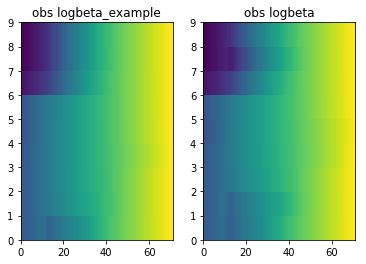

In [7]:
logbeta=backward(obsloglik,logPi,logA)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(logbeta_ex.T)
ax[0].set_title('obs logbeta_example')
ax[1].set_title('obs logbeta')
ax[1].pcolormesh(logbeta.T)
plt.show()

In [8]:
vloglik,path=viterbi(obsloglik,logPi,logA)
print(vloglik,path)
print(vloglik_ex,vpath_ex)

-5974.211288357338[0 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 8 8 8 8 8 8 8 8 8]
-5974.211288357338[0 1 1 1 2 2 2 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6 6 7 8 8 8 8 8 8 8 8 8 8]


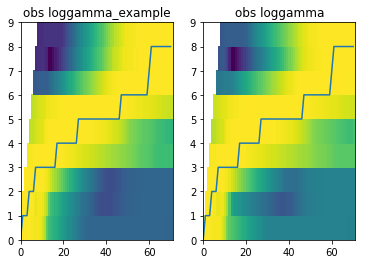

In [9]:
loggamma=statePosteriors(logalpha, logbeta)
fig, ax = plt.subplots(ncols=2)
ax[0].pcolormesh(loggamma_ex.T)
ax[0].plot(vpath_ex)
ax[0].set_title('obs loggamma_example')
ax[1].set_title('obs loggamma')
ax[1].plot(path)
ax[1].pcolormesh(loggamma.T)
plt.show()

In [12]:
def baum_welch(X, wordHMM, max_iter=20, thresh=1.0,plotLikelihood=False):
    ''' 
    Params:
        X: lmfcc features for utterance
        wordHMM: HMM models for words
        max_iter: maximum number of iterations to run baum welch algorithm for
        thresh: stopping criteria for baum welch. Algorithm stops when log likelihood no longer increases by >= thresh 
    Returns:
        likelihood: likelihood of data given final model
    '''
    curr_likelihood = None
    likelihood = 0
    plt_=[]

    for i in range(max_iter):
        # expectatiton step: compute alpha, beta and gamma probabilities for utterance using current model parameters
        obsloglik = log_multivariate_normal_density_diag(X, wordHMM['means'], wordHMM['covars']) # problem is here with nans
        alphas = forward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        likelihood=logsumexp(alphas[-1])
   
        betas = backward(obsloglik, np.log(wordHMM['startprob']), np.log(wordHMM['transmat']))
        # maximisation step: update means and variances using posteriors (gammas)
        gammas = statePosteriors(alphas, betas)
        wordHMM['means'], wordHMM['covars'] = updateMeanAndVar(X, gammas)

        # estimate likelihood of data given new model 
       
        if curr_likelihood is not None and likelihood < (curr_likelihood + thresh):
            break

        curr_likelihood = likelihood
        plt_.append(curr_likelihood)

    print('Number of iterations', i+1)
    print('Likelihood', likelihood)
    if(plotLikelihood):
        plt.plot(plt_)
        plt.xlabel('Iteration')
        plt.ylabel('log likelihood')
        plt.show()
    return likelihood, plt_

In [11]:
b=wordHMMs['o'].copy()
lik, plt_ = baum_welch(data[10]['lmfcc'], b, max_iter=10,plotLikelihood=True)

ValueError: operands could not be broadcast together with shapes (9,) (8,) 